In [1]:
using DrWatson
@quickactivate "haram"

In [2]:
using main
using Plots, Random, Distributions, ProgressMeter
using Flux, Turing

gr()
default(fmt=:png)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function plot_colorbar(cls)
    scatter([0, 0], [0, 1],
        zcolor=[0, 1], clims=(0, 1), xlims=(1, 1.1), c=cls,
        label="", colorbar_title="", framestyle=:none
    )
end

function nn_plot(theta; res=25, c=:viridis)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> reconstruct(theta)([x, y])[1],
        c=c, levels=50, lw=0.5,
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ts),
        m=map(x -> x == 1 ? :square : :circle, ts),
        group=ts,
        legend=:bottomright
    )
end

function nn_plot_mean(thetas; c=:viridis, res=25)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> mean([reconstruct(theta)([x, y])[1] for theta in eachrow(thetas)]), 
        c=c, levels=50, lw=0.5,
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ts),
        m=map(x -> x == 1 ? :square : :circle, ts),
        group=ts,
        legend=:bottomright
    )
end

nn_plot_mean (generic function with 1 method)

In [4]:
Random.seed!(2022)
s = 1.25
μ = [[1.0 1.0], [-1.0 -1.0], [1.0 -1.0], [-1.0 1.0],] .* 2
x0 = [s .* randn(30, 2) .+ μ[1]; s .* randn(100, 2) .+ μ[2]]
x1 = [s .* randn(10, 2) .+ μ[3]; s .* randn(80, 2) .+ μ[4]]
xs = [x0; x1]
ts = [zeros(size(x0, 1)); ones(size(x1, 1))] .|> Int;

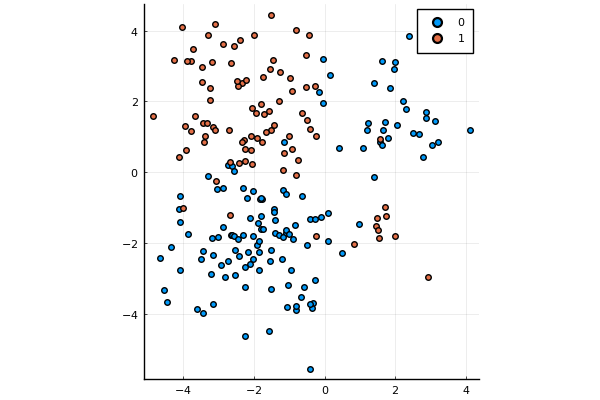

In [5]:
scatter(Tuple.(eachrow(xs)), group=ts, ratio=1)

In [6]:
nn = Chain(
    Dense(2, 3, tanh),
    Dense(3, 2, tanh),
    Dense(2, 1, sigmoid)
)

parameters_initial, reconstruct = Flux.destructure(nn)
sigma = sqrt(1.0 / 0.09)

@model function bayes_nn(xs, ts, nparameters, reconstruct)
    parameters ~ MvNormal(zeros(nparameters), sigma .* ones(nparameters))
    nn = reconstruct(parameters)
    preds = nn(xs)
    for i in eachindex(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

U(x) = -logjoint(bayes_nn(xs', ts, length(parameters_initial), reconstruct), (; parameters=x))
f(x) = exp(U(x))
model = Model(ξ=mod, d=20, f=f, U=U);

In [7]:
Random.seed!(2022)
@time s1, a1 = mcmc(
    main.HMC(ϵ=0.05, L=4),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :];

Progress:   0%|                                         |  ETA: 1 days, 8:38:43
4m  main.HMC:  0.6666666666666666
Progress:  14%|█████▌                                   |  ETA: 0:04:47
4m  main.HMC:  0.8779284833538841
Progress:  14%|█████▊                                   |  ETA: 0:04:39
4m  main.HMC:  0.8778443113772455
Progress:  14%|█████▉                                   |  ETA: 0:04:31
4m  main.HMC:  0.8785046728971962
Progress:  15%|██████                                   |  ETA: 0:04:24
4m  main.HMC:  0.8815489749430524
Progress:  15%|██████▏                                  |  ETA: 0:04:18
4m  main.HMC:  0.8819599109131403
Progress:  15%|██████▎                                  |  ETA: 0:04:11
4m  main.HMC:  0.8824809575625681
Progress:  16%|██████▍                                  |  ETA: 0:04:06
4m  main.HMC:  0.8840425531914894
Progress:  16%|██████▌                                  |  ETA: 0:04:00
4m  main.HMC:  0.8813735691987513
Progress:  16%|██████▊                

Acceptance Ratio = 0.8021
 75.402003 seconds (146.58 M allocations: 30.852 GiB, 7.28% gc time, 53.98% compilation time: 0% of which was recompilation)


In [8]:
Random.seed!(2022)
@time s2, a2 = mcmc(
    HaRAM(ϵ=0.05, L=4, γ=0.3),
    model; n=5e3, n_burn=1e3
)
x_haram = s2[a2, :];

Progress:   0%|                                         |  ETA: 0:31:09
4m  HaRAM:  0.6666666666666666
Progress:   0%|▏                                        |  ETA: 0:05:22
4m  HaRAM:  0.6666666666666666
Progress:   0%|▏                                        |  ETA: 0:03:33
4m  HaRAM:  0.6666666666666666
Progress:   1%|▎                                        |  ETA: 0:02:56
4m  HaRAM:  0.6944444444444444
Progress:   1%|▎                                        |  ETA: 0:02:37
4m  HaRAM:  0.6444444444444445
Progress:   1%|▍                                        |  ETA: 0:02:17
4m  HaRAM:  0.5178571428571429
Progress:   1%|▍                                        |  ETA: 0:02:10
4m  HaRAM:  0.5538461538461539
Progress:   1%|▌                                        |  ETA: 0:01:59
4m  HaRAM:  0.5526315789473685
Progress:   1%|▋                                        |  ETA: 0:01:54
4m  HaRAM:  0.5882352941176471
Progress:   2%|▋                                        |  ETA: 0:01:47
4

Acceptance Ratio = 0.6355
 69.441729 seconds (168.94 M allocations: 55.571 GiB, 11.09% gc time, 0.91% compilation time)


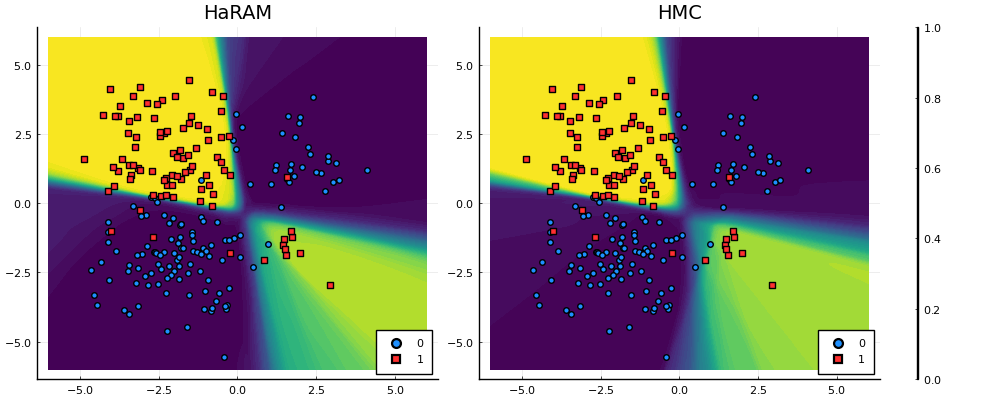

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


In [9]:
st, res = 50, 200
cls = palette(:viridis, rev=false)
plot(
    plot(
        nn_plot_mean(x_haram[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HaRAM", lsw=0.0, fsw=0.0, lw=0.0
    ),
    plot(
        nn_plot_mean(x_hmc[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HMC"
    ),
    plot_colorbar(cls),
    layout=(@layout [grid(1, 2) a{0.035w}]),
    link=:all,
    size=(1000, 400)
)